In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import geopandas as gpd
from bs4 import BeautifulSoup 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from functools import reduce

# import planning area

<class 'geopandas.geodataframe.GeoDataFrame'>


Name                                        Description  \
0  kml_1  <center><table><tr><th colspan='2' align='cent...   
1  kml_2  <center><table><tr><th colspan='2' align='cent...   
2  kml_3  <center><table><tr><th colspan='2' align='cent...   
3  kml_4  <center><table><tr><th colspan='2' align='cent...   
4  kml_5  <center><table><tr><th colspan='2' align='cent...   

                                            geometry     PLN_AREA_N  \
0  POLYGON Z ((103.93208 1.30555 0, 103.93208 1.3...          BEDOK   
1  POLYGON Z ((103.72042 1.32824 0, 103.72003 1.3...       BOON LAY   
2  POLYGON Z ((103.76408 1.37001 0, 103.76444 1.3...    BUKIT BATOK   
3  POLYGON Z ((103.82361 1.26018 0, 103.82362 1.2...    BUKIT MERAH   
4  POLYGON Z ((103.77445 1.39029 0, 103.77499 1.3...  BUKIT PANJANG   

  PLN_AREA_C CA_IND        REGION_N REGION_C           INC_CRC      FMEL_UPD_D  
0         BD      N     EAST REGION       ER  5F00E6FF084F3364  20191223152014  
1         BL      N     WEST REGION       WR  C96AED188C00B2FC  20191223152014  
2         BK      N     WEST REGION       WR  3BEC4C829160F28A  20191223152014  
3         BM      N  CENTRAL REGION       CR  4850795BB0B6A4F7  20191223152014  
4         BP      N     WEST REGION       WR  656F87D23D6DAB02  20191223152014

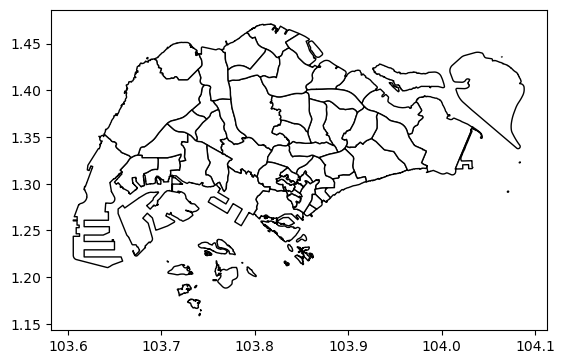

In [2]:

planningArea_noSea = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019PlanningAreaBoundaryNoSea.geojson")

def extract_html_tags(row):
    html_content = row["Description"]
    soup = BeautifulSoup(html_content,"html.parser")
    ths = soup.find_all('th')
    tds = soup.find_all('td')
    column_names = []
    column_values = []
    for th in ths:
        column_names.append(th.get_text())
    for td in tds:
        column_values.append(td.get_text())
    column_names = column_names[1:] # remove the first "Attribute"
    return pd.Series({k:v for k,v in zip(column_names,column_values)})
# column_names, _ = extract_html_tags(planningArea_noSea.iloc[0,1])
planningArea_shp = planningArea_noSea.join(planningArea_noSea.apply(extract_html_tags,axis=1))
print(type(planningArea_shp))
planningArea_shp.plot(fc='white',ec='k')
planningArea_shp.head()

# Import filepaths

- replace income quintiles with household median income
- add schools and workplace as one single layer
- normalise NonACHouseholds by total population of planning area

In [43]:
save_dir = r"HRI_analysis\data"
# # data_fps = {fp.replace(".csv","").replace("planningArea","").replace("_",""): os.path.join(save_dir,d,fp) for d in os.listdir(save_dir) for fp in os.listdir(os.path.join(save_dir,d)) if (fp.endswith('.csv') and 'planningArea' in fp and not bool(re.search("NDVI|minMax",fp)))}
# data_fps = {fp.replace(".csv","").replace("planningArea","").replace("_",""): os.path.join(save_dir,d,fp) for d in os.listdir(save_dir) for fp in os.listdir(os.path.join(save_dir,d)) if (bool(re.search(".*planningArea.*.csv$",fp)) and not bool(re.search("NDVI|minMax|Quintile",fp)))}
# data_fps = {k: data_fps[k] for k in list(data_fps)[:-2]}
# data_fps
risk_dir = {param: os.path.join(save_dir,param) for param in ["Hazard","Exposure","Vulnerability"]}
risk_dfs = {param: {os.path.splitext(fp)[0]: pd.read_csv(os.path.join(dir_fp,fp)) for fp in os.listdir(dir_fp) if fp.endswith(".csv")} for param, dir_fp in risk_dir.items()}
# rename columns
risk_dfs = {param: {df_name: df.rename(columns = lambda x: 'PLN_AREA_N' if 'PLN_AREA_N' in x else x) for df_name, df in df_list.items()} for param, df_list in risk_dfs.items()}
# drop duplicated columns
risk_dfs = {param: {df_name: df.loc[:,~df.columns.duplicated()].copy() for df_name, df in df_list.items()} for param, df_list in risk_dfs.items()}
risk_dfs


{'Hazard': {'WBGT_coolest':                  PLN_AREA_N  WBGT_coolest
  0                ANG MO KIO     25.567545
  1                     BEDOK     26.034882
  2                    BISHAN     25.780380
  3                  BOON LAY     25.940038
  4               BUKIT BATOK     25.737373
  5               BUKIT MERAH     26.277024
  6             BUKIT PANJANG     25.652237
  7               BUKIT TIMAH     25.743159
  8   CENTRAL WATER CATCHMENT     25.690613
  9                    CHANGI     25.797375
  10               CHANGI BAY     26.269699
  11            CHOA CHU KANG     25.751274
  12                 CLEMENTI     26.051920
  13            DOWNTOWN CORE     26.307147
  14                  GEYLANG     26.017642
  15                  HOUGANG     25.672320
  16              JURONG EAST     26.064658
  17              JURONG WEST     25.826183
  18                  KALLANG     26.137923
  19             LIM CHU KANG     25.742576
  20                   MANDAI     25.308803
  21  

In [45]:
risk_dfs['Vulnerability']['ElectricityConsumption']['PLN_AREA_N'] = risk_dfs['Vulnerability']['ElectricityConsumption']['PLN_AREA_N'].str.upper()
risk_dfs['Vulnerability']['ElectricityConsumption']

Dwelling Type  Year  Month             Region        PLN_AREA_N  \
0        Overall  2018      5        West Region       JURONG EAST   
1        Overall  2018      5     Central Region            OUTRAM   
2        Overall  2018      5     Central Region       BUKIT MERAH   
3        Overall  2018      5     Central Region        QUEENSTOWN   
4        Overall  2018      5  North East Region        ANG MO KIO   
5        Overall  2018      5        West Region       BUKIT BATOK   
6        Overall  2018      5  North East Region           PUNGGOL   
7        Overall  2018      5        West Region       JURONG WEST   
8        Overall  2018      5     Central Region         TOA PAYOH   
9        Overall  2018      5        West Region     CHOA CHU KANG   
10       Overall  2018      5       North Region            YISHUN   
11       Overall  2018      5       North Region         SEMBAWANG   
12       Overall  2018      5       North Region         WOODLANDS   
13       Overall  2018      5  North East Region          SENGKANG   
14       Overall  2018      5        West Region          CLEMENTI   
15       Overall  2018      5     Central Region           KALLANG   
16       Overall  2018      5        East Region          TAMPINES   
17       Overall  2018      5        West Region     BUKIT PANJANG   
18       Overall  2018      5  North East Region           HOUGANG   
19       Overall  2018      5        East Region            CHANGI   
20       Overall  2018      5     Central Region     DOWNTOWN CORE   
21       Overall  2018      5            Overall           OVERALL   
22       Overall  2018      5     Central Region           GEYLANG   
23       Overall  2018      5        East Region         PASIR RIS   
24       Overall  2018      5     Central Region            BISHAN   
25       Overall  2018      5     Central Region            ROCHOR   
26       Overall  2018      5        East Region             BEDOK   
27       Overall  2018      5  North East Region         SERANGOON   
28       Overall  2018      5     Central Region     MARINE PARADE   
29       Overall  2018      5     Central Region            MUSEUM   
30       Overall  2018      5       North Region            MANDAI   
31       Overall  2018      5     Central Region            NOVENA   
32       Overall  2018      5     Central Region   SINGAPORE RIVER   
33       Overall  2018      5  North East Region           SELETAR   
34       Overall  2018      5     Central Region           ORCHARD   
35       Overall  2018      5     Central Region      RIVER VALLEY   
36       Overall  2018      5     Central Region       BUKIT TIMAH   
37       Overall  2018      5     Central Region            NEWTON   
38       Overall  2018      5       North Region      SUNGEI KADUT   
39       Overall  2018      5     Central Region           TANGLIN   
40       Overall  2018      5        East Region        PAYA LEBAR   
41       Overall  2018      5     Central Region  SOUTHERN ISLANDS   

    HouseholdElectricityConsumption_kwh  Household size (2019)  
0                                 337.3                   3.16  
1                                 345.0                   3.16  
2                                 347.4                   3.16  
3                                 353.7                   3.16  
4                                 369.7                   3.16  
5                                 372.4                   3.16  
6                                 372.4                   3.16  
7                                 375.0                   3.16  
8                                 379.5                   3.16  
9                                 382.1                   3.16  
10                                398.1                   3.16  
11                                398.8                   3.16  
12                                403.8                   3.16  
13                                413.2                   3.16  
14               

In [46]:
risk_dfs['Vulnerability'].keys()

dict_keys(['ACHouseholds', 'ElectricityConsumption', 'Household median income', 'minMean_travelTime_Hospital', 'PopPerClinic', 'PublicTransitCatchmentFactor', 'ShadeFactor', 'VulnerablePop'])

In [47]:
risk_dfs['Vulnerability']['ElectricityConsumption'].columns

Index(['Dwelling Type', 'Year', 'Month', 'Region', 'PLN_AREA_N',
       'HouseholdElectricityConsumption_kwh', 'Household size (2019)'],
      dtype='object')

### Rename df columns

In [48]:
exposure_columns = {'DayTimePop': {'TotalDayTimePop':'DayTimePop'},
                    'NightTimePop': {'ResidentPopTotalAll': 'NightTimePop'}
                    }

vulnerability_columns = {#'Greenspaces': {'Intersect_Statistics.SUM_ParkArea': 'PublicParkFactor'},
                        'Household median income': {'Median Income Ratio (Straits Times)': 'RelativeMedianIncome'},
                        'minMean_travelTime_Hospital': {'min_travel_time':'HospitalTravelTime'},
                        'PublicTransitCatchmentFactor':{'PublicTransitCatchmentFactor':'PublicTransitCatchmentFactor'},
                        'ShadeFactor': {'ShadeFactor': 'ShelterFactor'},
                        'ACHouseholds': {'ACHouseholds': 'ACHouseholds'},
                        'PopPerClinic': {'Pop/Clinic': 'ClinicLoadFactor'},
                        'ElectricityConsumption': {'HouseholdElectricityConsumption_kwh':'HouseholdElectricityConsumption_kwh'},
                        'VulnerablePop': {'ResidentPopTotal0_14':'Below14_yo','ResidentPopTotal_60andOver':'Above60'}
                        }

hazard_columns = {df_name: {df_name : df_name} for df_name in risk_dfs['Hazard'].keys()}

rename_columns = {"Hazard": hazard_columns,"Exposure": exposure_columns,"Vulnerability":vulnerability_columns}

risk_dfs = {param: {df_name: df.loc[:,['PLN_AREA_N']+list(rename_columns[param][df_name])].rename(columns = rename_columns[param][df_name]) for df_name, df in df_list.items()} for param, df_list in risk_dfs.items()}
risk_dfs

{'Hazard': {'WBGT_coolest':                  PLN_AREA_N  WBGT_coolest
  0                ANG MO KIO     25.567545
  1                     BEDOK     26.034882
  2                    BISHAN     25.780380
  3                  BOON LAY     25.940038
  4               BUKIT BATOK     25.737373
  5               BUKIT MERAH     26.277024
  6             BUKIT PANJANG     25.652237
  7               BUKIT TIMAH     25.743159
  8   CENTRAL WATER CATCHMENT     25.690613
  9                    CHANGI     25.797375
  10               CHANGI BAY     26.269699
  11            CHOA CHU KANG     25.751274
  12                 CLEMENTI     26.051920
  13            DOWNTOWN CORE     26.307147
  14                  GEYLANG     26.017642
  15                  HOUGANG     25.672320
  16              JURONG EAST     26.064658
  17              JURONG WEST     25.826183
  18                  KALLANG     26.137923
  19             LIM CHU KANG     25.742576
  20                   MANDAI     25.308803
  21  

### Combine columns

In [49]:
# merge all dfs_filtered_columns by PLN_AREA_N
# merge dfs by petals
risk_combined_dfs = {param:  reduce(lambda x, y: pd.merge(x, y, on = 'PLN_AREA_N',how='outer'), list(df_list.values())) for param, df_list in risk_dfs.items()}
# filter planning areas
selected_planning_areas = [i for i in planningArea_shp['PLN_AREA_N'].to_list() if not bool(re.search("ISLAND",i))]
risk_combined_dfs = {param: df[df['PLN_AREA_N'].isin(selected_planning_areas)] for param, df in risk_combined_dfs.items()}
# convert to float for all numeric columns
for param, df in risk_combined_dfs.items():
    risk_combined_dfs[param][df.columns[1:]] = df[df.columns[1:]].apply(lambda x: pd.to_numeric(x,errors="coerce"))
risk_combined_dfs

# merge all columns
HRI_df = reduce(lambda x, y: pd.merge(x, y, on = 'PLN_AREA_N',how='outer'), list(risk_combined_dfs.values()))
print("Length of HRI df:", len(HRI_df))

Length of HRI df: 52


In [50]:
HRI_df.head()

PLN_AREA_N  WBGT_coolest  WBGT_hottest  DayTimePop  NightTimePop  \
0   ANG MO KIO     25.567545     32.458502     97523.0      162280.0   
1        BEDOK     26.034882     33.014266     89993.0      276990.0   
2       BISHAN     25.780380     32.692232     43646.0       87320.0   
3     BOON LAY     25.940038     32.243321     19300.0          40.0   
4  BUKIT BATOK     25.737373     32.723510     47273.0      158030.0   

   ACHouseholds  HouseholdElectricityConsumption_kwh  RelativeMedianIncome  \
0      150055.0                                369.7              0.742706   
1      257187.0                                477.5              0.954907   
2       81343.0                                463.0              1.273210   
3           NaN                                  NaN                   NaN   
4      147008.0                                372.4              0.848806   

   HospitalTravelTime  ClinicLoadFactor  PublicTransitCatchmentFactor  \
0          428.467141        179.064039                      0.215179   
1          322.324601        155.421991                      0.293753   
2          350.152018        382.574058                      0.277741   
3          384.201006          2.414653                      0.101877   
4          229.263267        337.752810                      0.269588   

   ShelterFactor  Below14_yo  Above60  
0       0.503229     18410.0  47950.0  
1       0.398234     34090.0  75230.0  
2       0.423072     10810.0  23170.0  
3       0.333986         0.0      0.0  
4       0.543815     22430.0  33420.0

# PCA analysis

Under Eigen-Vectors, we can say that Principal components show both common and unique variance of the variable. Basically, it is variance focused approach seeking to reproduce total variance and correlation with all components. The principal components are basically the linear combinations of the original variables weighted by their contribution to explain the variance in a particular orthogonal dimension.

## Eigen Values
It is basically known as characteristic roots. It basically measures the variance in all variables which is accounted for by that factor. The ratio of eigenvalues is the ratio of explanatory importance of the factors with respect to the variables. If the factor is low then it is contributing less to the explanation of variables. In simple words, it measures the amount of variance in the total given database accounted by the factor. We can calculate the factor's eigenvalue as the sum of its squared factor loading for all the variables.

### HRI_dfs
- Drop rows with NAs
- imputation with 0

In [21]:
# remove rows with NAs
def dropNA_imputeNA(df):
    """  
    impute dfs with 0 and drop NAs in df
    """
    print("NAs in HRI_df:", df.isna().sum())
    df_noNAs = df.dropna()
    print("length of df_noNAs:", len(df_noNAs))

    # imput NAs with 0
    df_imputed = df.fillna(0)
    print("length of df_imputed:", len(df_imputed))

    dfs = {'noNAs': df_noNAs,
                'imputed': df_imputed}
    return dfs

def get_PCA_results(df):
    # important to do scaling before PCA
    sc = StandardScaler()
    HRI_standardized = sc.fit_transform(df.iloc[:,1:])  # Exclude PLN_AREA_N for scaling
    # print(HRI_standardized)
    pca = PCA(n_components=None)
    HRI_PCA = pca.fit(HRI_standardized)
    # Percentage of variance explained by each of the selected components. 
    # The values are sorted by decreasing explained_variance_, thus it doesnt directly correspond to the order of the original features.
    var = pca.explained_variance_ratio_
    # features contribute to principal components through the loadings (i.e. coefficients of the linear combination of the original features that form the principal components).
    # components_ tells us how strongly each original feature correlates with each PC
    loadings = pca.components_
    # Create a DataFrame for loadings with original feature names, display the loadings for each principal component
    # look at the absolute values in each row, the large the absolute value, the more influence that feature has on that PC
    # each row in loadings_df correspond to a principal component, and each column corresponds to an original feature. The values indicate how much each feature contributes to that PC
    # e.g. the first row corresponds to the first principal component, and the values in that row indicate how much each original feature contributes to that PC
    loadings_df = pd.DataFrame(loadings, columns=df.columns[1:])
    return {'explained_variance': var,'loadings_df': loadings_df,'standardised_df': HRI_standardized}

# plot scree plot of the first principal components
def scree_plot(explained_variance, title='Scree Plot',label=None,ax=None):
    """
    Plot the scree plot of the PCA results.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', label=label,alpha=0.5)
    
    ax.set_title(title)
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Variance Explained')
    ax.set_xticks(range(1, len(explained_variance) + 1))
    # plt.legend()
    if ax is None:
        plt.show()
    return ax

In [52]:
pca_results = dict()
# do PCA for each hazard
for df_type, df in risk_combined_dfs.items():
    # treatment of NAs
    df_noNA_dict = dropNA_imputeNA(df)
    nonNA_pca_results = dict()
    for NAtype, df in df_noNA_dict.items():
        df_noNA_dict[NAtype] = get_PCA_results(df)
    pca_results[df_type] = df_noNA_dict

# do PCA for HRI overall
df_noNA_dict = dropNA_imputeNA(HRI_df)
nonNA_pca_results = dict()
for NAtype, df in df_noNA_dict.items():
    df_noNA_dict[NAtype] = get_PCA_results(df)
pca_results['HRI_overall'] = df_noNA_dict
pca_results

NAs in HRI_df: PLN_AREA_N      0
WBGT_coolest    0
WBGT_hottest    0
dtype: int64
length of df_noNAs: 52
length of df_imputed: 52
NAs in HRI_df: PLN_AREA_N      0
DayTimePop      0
NightTimePop    0
dtype: int64
length of df_noNAs: 52
length of df_imputed: 52
NAs in HRI_df: PLN_AREA_N                              0
ACHouseholds                           16
HouseholdElectricityConsumption_kwh    12
RelativeMedianIncome                   16
HospitalTravelTime                      0
ClinicLoadFactor                        8
PublicTransitCatchmentFactor            1
ShelterFactor                           0
Below14_yo                              0
Above60                                 0
dtype: int64
length of df_noNAs: 35
length of df_imputed: 52
NAs in HRI_df: PLN_AREA_N                              0
WBGT_coolest                            0
WBGT_hottest                            0
DayTimePop                              0
NightTimePop                            0
ACHouseholds       

{'Hazard': {'noNAs': {'explained_variance': array([0.60927562, 0.39072438]),
   'loadings_df':    WBGT_coolest  WBGT_hottest
   0      0.707107      0.707107
   1     -0.707107      0.707107,
   'standardised_df': array([[-1.42135334e+00, -5.72573850e-01],
          [ 3.12037853e-01,  4.95814559e-01],
          [-6.31930899e-01, -1.23256473e-01],
          [-3.97463072e-02, -9.86233041e-01],
          [-7.91447382e-01, -6.31283381e-02],
          [ 1.21016235e+00,  3.54344850e-01],
          [-1.10722378e+00, -7.27457912e-01],
          [-7.69986635e-01,  4.57986008e-01],
          [-9.64884050e-01, -1.85768345e+00],
          [-5.68895052e-01, -7.68735209e-01],
          [ 1.18299333e+00, -9.38000580e-01],
          [-7.39887435e-01,  7.50696873e-01],
          [ 3.75233189e-01, -5.37086866e-02],
          [ 1.32189102e+00,  1.16319302e+00],
          [ 2.48093281e-01,  1.09462373e+00],
          [-1.03273428e+00,  7.71360401e-02],
          [ 4.22479474e-01, -6.90504042e-01],
       

if $n$ is the number of observations and $p$ is the number of dimensions and $n \leq p$, then the number of principal components with non-zero variance cannot exceed $n$ (when doing PCA on raw data) or $n-1$ (when doing PCA on centered data)

[PCA when the dimensionality is greater than n](https://stats.stackexchange.com/questions/28909/pca-when-the-dimensionality-is-greater-than-the-number-of-samples)

In [53]:
pca_results.keys()

dict_keys(['Hazard', 'Exposure', 'Vulnerability', 'HRI_overall'])

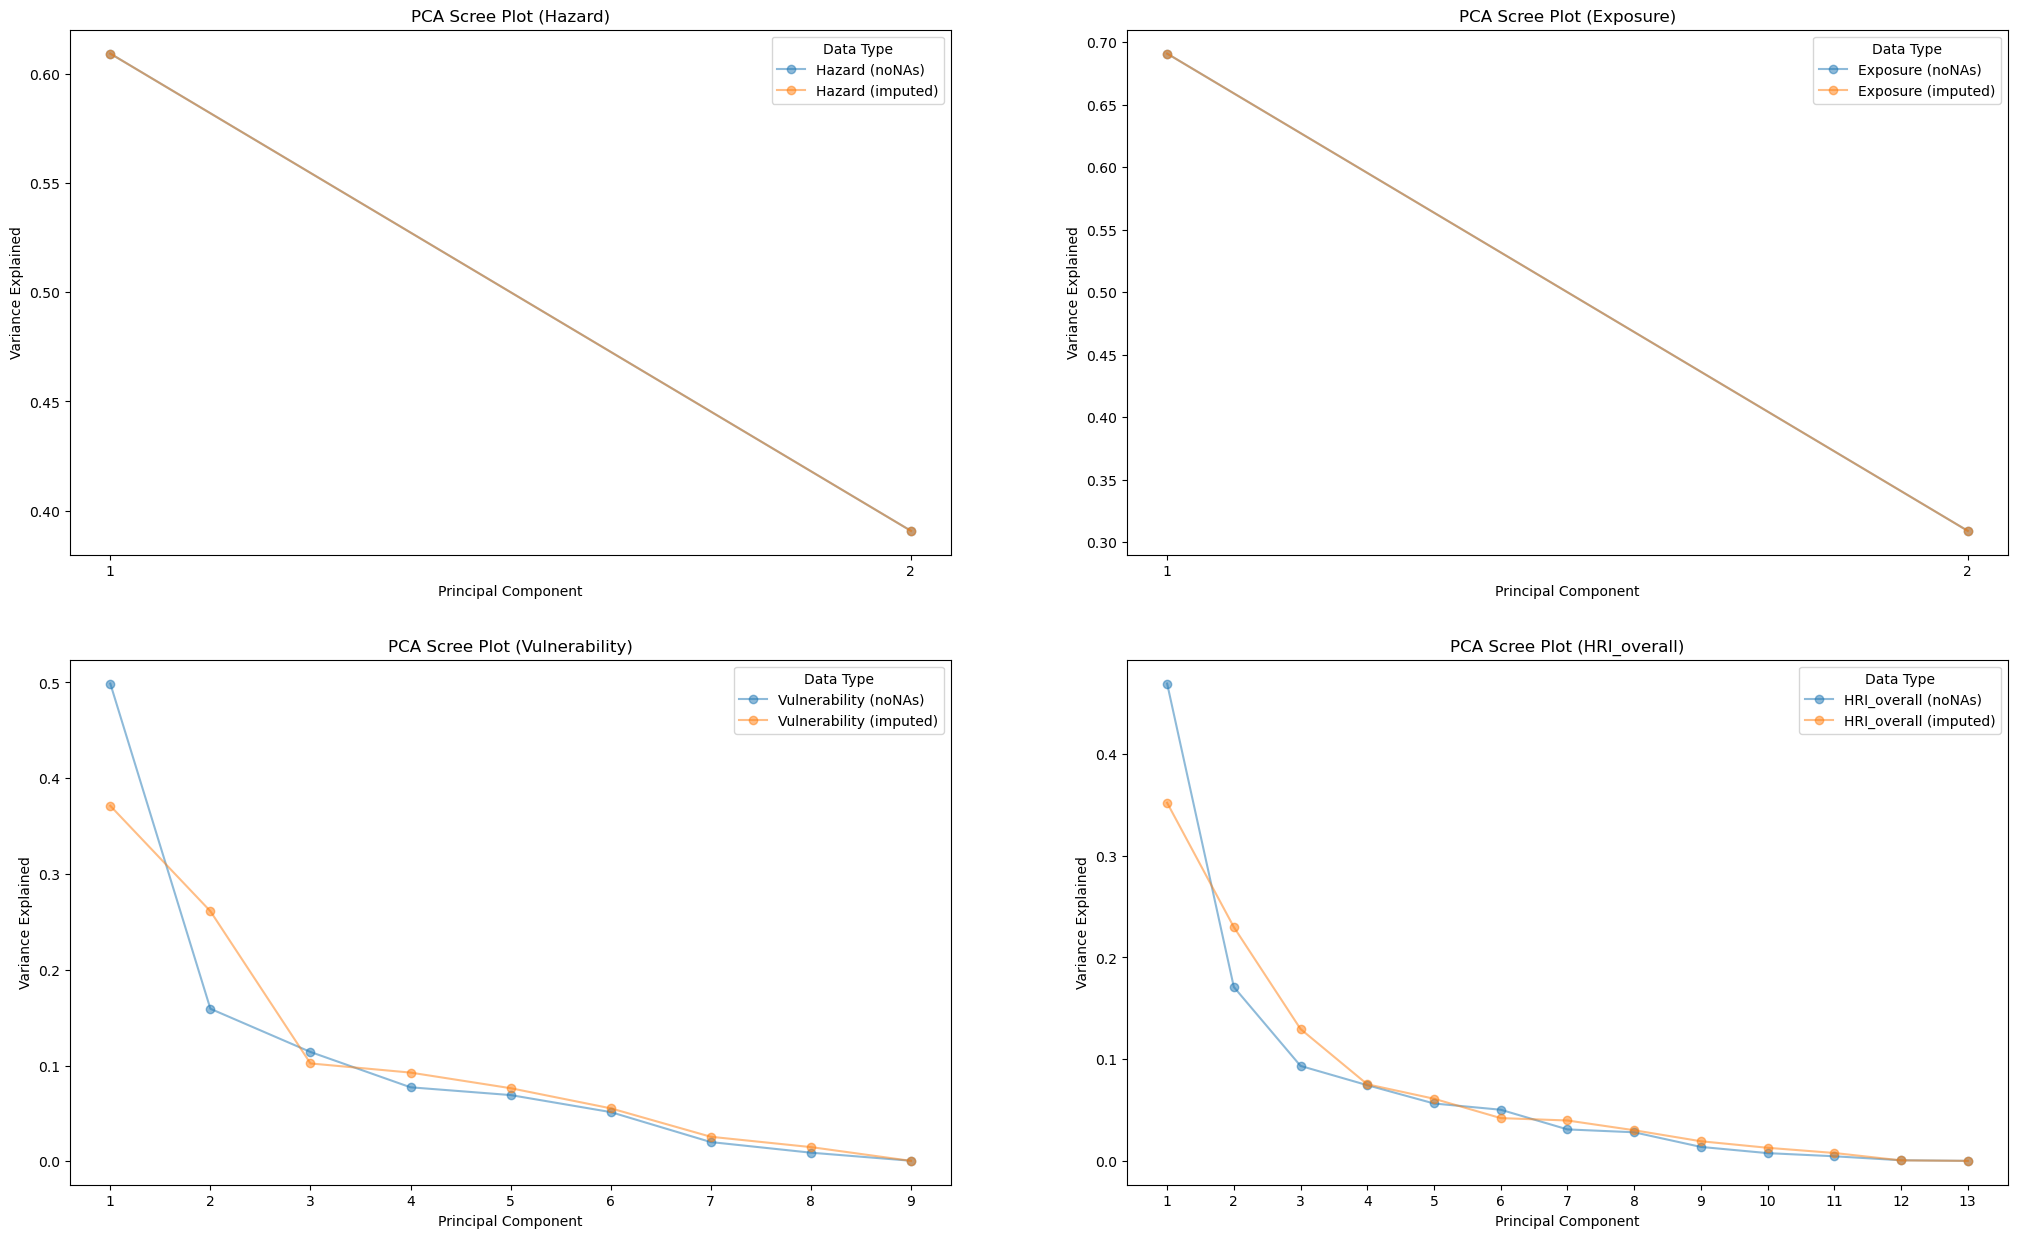

In [54]:
# how complex a model can you afford with only 100 samples?
# And that question I usually answer with: much less than 100 PCs. 
fig, axes = plt.subplots(2,2,figsize=(25,15))
for ax, (df_type,na_dict) in zip(axes.flatten(),pca_results.items()):
    # fig, ax = plt.subplots(figsize=(15,8))
    for na_type in na_dict.keys():
        ax = scree_plot(pca_results[df_type][na_type]['explained_variance'], title=f'PCA Scree Plot ({df_type})', ax=ax,label=f"{df_type} ({na_type})")
    # plot legend from handles
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right', title='Data Type')
fig.savefig(os.path.join(r"data",f"PCA_Scree_plots_reduced.png"),bbox_inches='tight')
plt.show()

### Multiply explained variance with loadings df

In [56]:
def get_feature_importance(loadings_df,explained_variance,n_components=None):
    """   calculate the weighted sum of absolute loadings
    Args:
        loadings_df (pd.DataFrame): loadings df shape: (nxm)
        explained_variance (np.ndarray): shape: (m,)
        n_components (int): number of first principal components to choose
    """
    if n_components is None:
        n_components = explained_variance.shape[0]
    weighted_sum_loadings = loadings_df.iloc[:n_components,:].apply(lambda x: x*explained_variance[:n_components].tolist(),axis=0).abs().sum(axis=0).sort_values(ascending=False).to_frame(name="sum of absolute loadings")
    return weighted_sum_loadings

get_feature_importance(loadings_df=pca_results['Vulnerability']['imputed']['loadings_df'],
                       explained_variance=pca_results['Vulnerability']['imputed']['explained_variance'],
                       n_components=4)

sum of absolute loadings
ACHouseholds                                         0.274724
Above60                                              0.268097
PublicTransitCatchmentFactor                         0.267701
Below14_yo                                           0.266489
RelativeMedianIncome                                 0.239368
HospitalTravelTime                                   0.236181
ClinicLoadFactor                                     0.222502
HouseholdElectricityConsumption_kwh                  0.212580
ShelterFactor                                        0.197660

In [58]:
for param in pca_results.keys():
    n_component = pca_results[param]['imputed']['explained_variance'].shape[0]
    weighted_sum_loadings = get_feature_importance(loadings_df=pca_results[param]['imputed']['loadings_df'],
                        explained_variance=pca_results[param]['imputed']['explained_variance'],
                        n_components=n_component)
    weighted_sum_loadings.round(5).to_csv(os.path.join(r"data",f"PCA_ranking_absolute_loadings_{param}_{n_component}nComponent.csv"))

# Correlation

In [32]:
def correlation_plot(corr_matrix, title='Correlation Matrix',
                     figsize=(12,12),cmap='coolwarm',labelsize=20,save_fp=None):
    """
    Plot the correlation matrix using seaborn heatmap.
    """
    corr_array = corr_matrix.values
    # mask out lower triangle
    # mask =  np.tri(corr_array.shape[0], k=-1)
    mask =  np.triu(corr_array, k=0)
    corr_array = np.ma.array(corr_array, mask=mask)
    # set cmap
    cmap = cm.get_cmap(cmap, 10) # jet doesn't have white color
    cmap.set_bad('w') # default value is 'k'

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(corr_array,cmap=cmap, aspect='auto')

    xlabels = corr_matrix.columns
    ylabels = corr_matrix.index

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(range(len(xlabels)), labels=xlabels,
                rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(len(ylabels)), labels=ylabels)

    # Loop over data dimensions and create text annotations.
    for i in range(len(ylabels)):
        for j in range(len(xlabels)):
            text = ax.text(j, i, f"{corr_array[i, j]:.3f}", 
                        ha="center", va="center", color="w",fontweight='bold')
    ax.spines[:].set_visible(False)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax_text_style = dict(horizontalalignment='center', verticalalignment='center',
                        fontsize=labelsize,weight='bold')
    ax.set_title(title,**ax_text_style)
    cbar = fig.colorbar(im, ax=ax, fraction=0.1)
    cbar.ax.tick_params(labelsize=labelsize)
    cbar.set_label(label="Correlation value",size=labelsize)
    fig.tight_layout()
    if save_fp is not None:
        fig.savefig(save_fp,bbox_inches='tight')
    
    plt.show()
    return corr_array

C:\Users\hypak\AppData\Local\Temp\ipykernel_19012\2036398797.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, 10) # jet doesn't have white color
C:\Users\hypak\AppData\Local\Temp\ipykernel_19012\2036398797.py:29: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  text = ax.text(j, i, f"{corr_array[i, j]:.3f}",


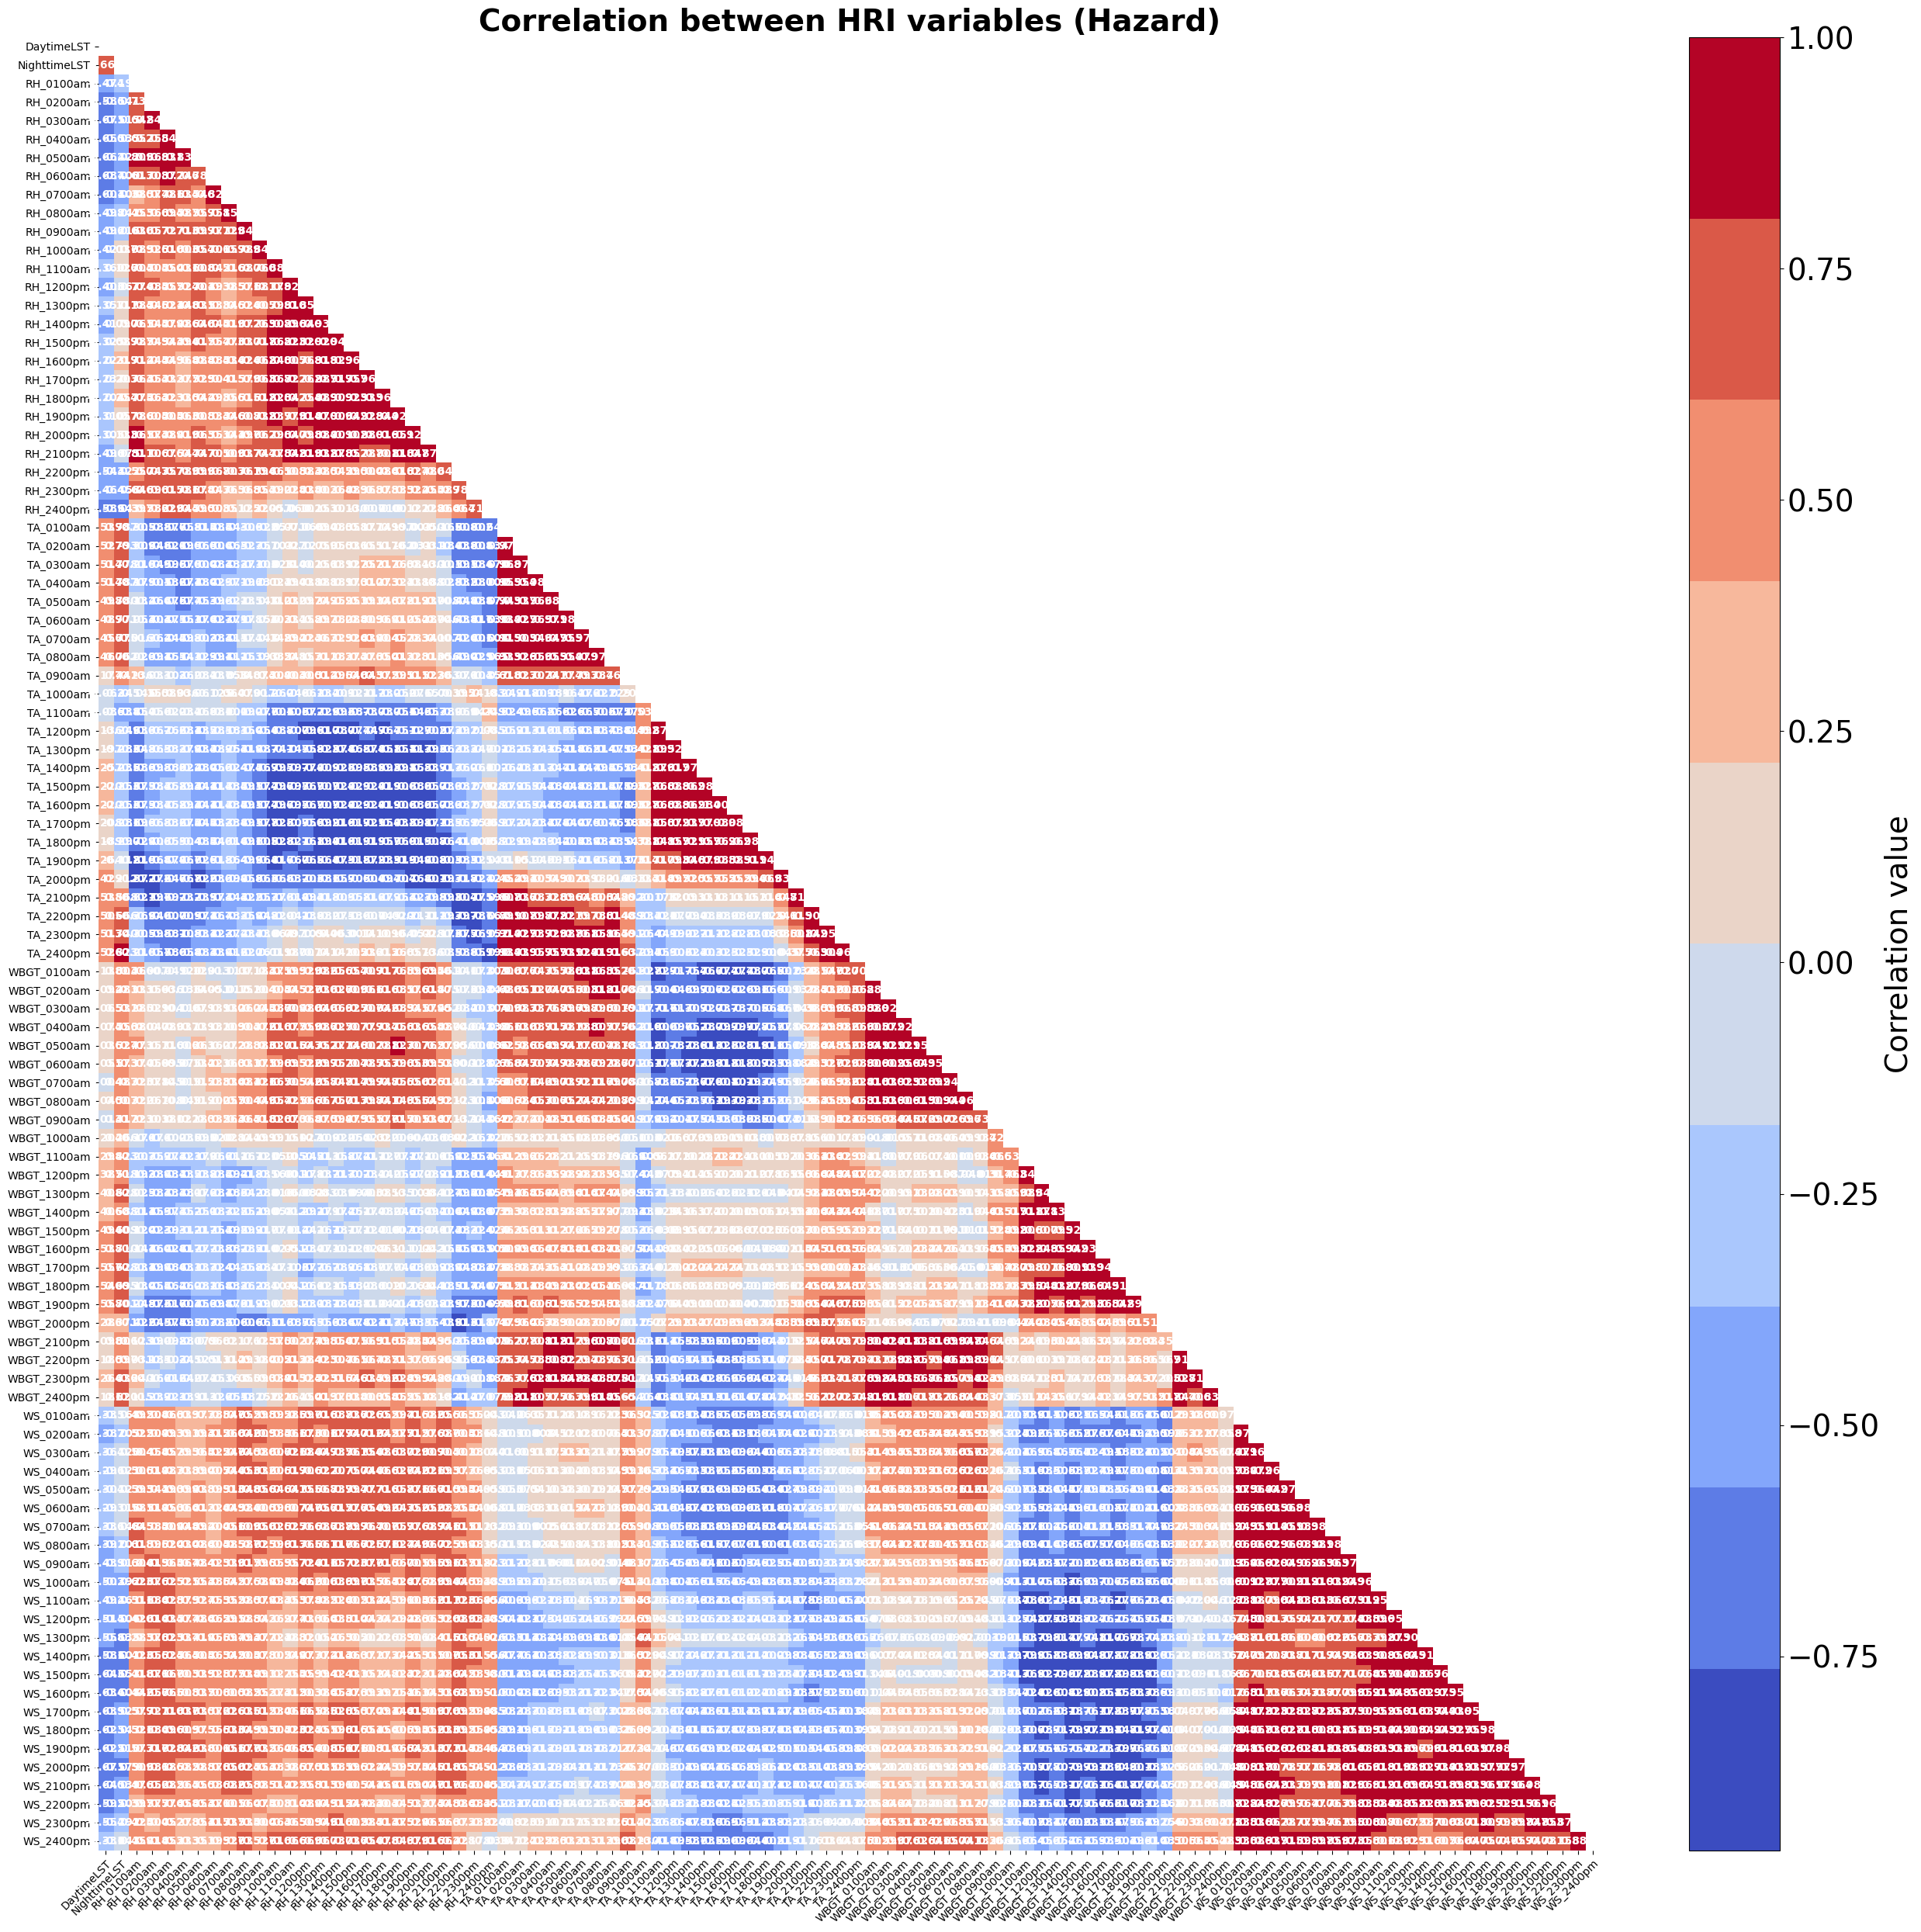

C:\Users\hypak\AppData\Local\Temp\ipykernel_19012\2036398797.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, 10) # jet doesn't have white color
C:\Users\hypak\AppData\Local\Temp\ipykernel_19012\2036398797.py:29: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  text = ax.text(j, i, f"{corr_array[i, j]:.3f}",


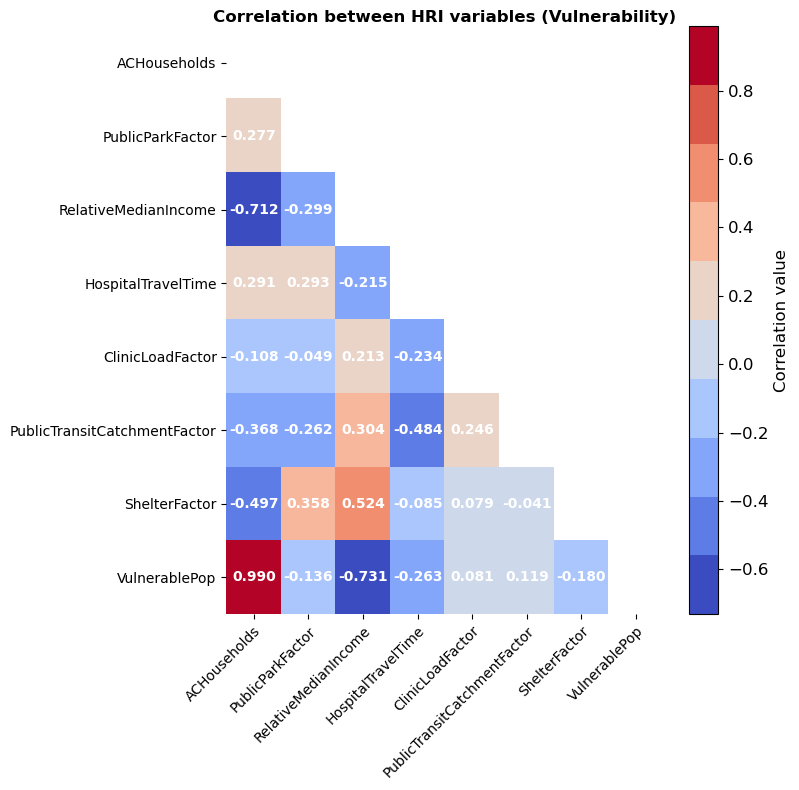

In [62]:
for param,figsize,labelsize in zip(['Hazard','Vulnerability'],[(25,25),(8,8)],[28,12]):
    correlation_plot(risk_combined_dfs[param].iloc[:,1:].corr(), 
                    figsize=figsize,cmap='coolwarm',
                    title=f'Correlation between HRI variables ({param})',
                    labelsize=labelsize,
                    save_fp=os.path.join(r"data",f"Correlation_heat_map_{param}.png"))

In [60]:
HRI_corr_arr = correlation_plot(HRI_df.iloc[:,1:].corr(), 
                    figsize=(12,12),cmap='coolwarm',labelsize=25,
                    title=f'Correlation between HRI variables ({param})')
HRI_corr_arr

C:\Users\hypak\AppData\Local\Temp\ipykernel_16728\2036398797.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, 10) # jet doesn't have white color
C:\Users\hypak\AppData\Local\Temp\ipykernel_16728\2036398797.py:29: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  text = ax.text(j, i, f"{corr_array[i, j]:.3f}",


masked_array(
  data=[[--, --, --, --, --, --, --, --, --, --, --, --, --],
        [0.21855123411070376, --, --, --, --, --, --, --, --, --, --, --,
         --],
        [0.09660429222266695, 0.2869150541082382, --, --, --, --, --, --,
         --, --, --, --, --],
        [-0.2884588652025871, 0.10493221539334795, 0.38192802645060453,
         --, --, --, --, --, --, --, --, --, --],
        [-0.4142706599391766, -0.38271895687445295, 0.18544855748535138,
         0.9999587051238523, --, --, --, --, --, --, --, --, --],
        [-0.11256040473235575, -0.010362905185703387,
         -0.4328911904059615, -0.573065945127718, -0.5612386854821068,
         --, --, --, --, --, --, --, --],
        [0.2038249532302025, 0.3499804592581655, -0.2614758304414947,
         -0.7153918094587223, -0.7122173740776547, 0.825035507602777, --,
         --, --, --, --, --, --],
        [-0.051037969537394055, -0.5353028212477191, -0.233144408383177,
         -0.24517201835881852, 0.29128033185017516, 0

In [42]:
def get_correlated_vars(arr,names,threshold=0.7):
    """   
    get variables with high correlation value above threshold
    """
    row_idx, column_idx = np.nonzero(arr>threshold)
    correlated_vars = [names[i] for i in row_idx]+[names[i] for i in column_idx]
    # remove duplicated vars
    correlated_vars = list(sorted(set(correlated_vars)))
    print(f"Length of correlated vars: {len(correlated_vars)}")
    return [(x,y) for x,y in zip([names[i] for i in row_idx],[names[i] for i in column_idx])]

correlated_vars = get_correlated_vars(arr=HRI_corr_arr,names=HRI_df.columns[1:].to_list(),threshold=0.7)
with open(os.path.join(r"data","Correlated_variable_pair.txt"), 'w') as f:
    for v in correlated_vars:
        f.write(f"{v[0]},{v[1]}\n")

Length of correlated vars: 98


In [43]:
with open(os.path.join(r"data","Correlated_variables.txt"), 'w') as f:
    for v in set([j for i in correlated_vars for j in i]):
        f.write(f"{v}\n")

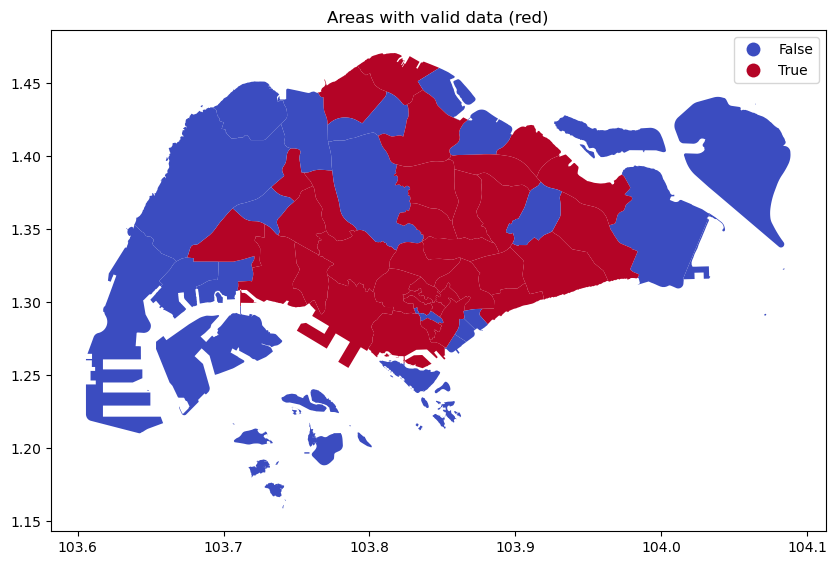

In [63]:
# add a column for planningArea that matches the planningArea_shp
# drop rows with NAs
HRI_valid = HRI_df.dropna()
planningArea_shp['valid_areas'] = planningArea_shp['PLN_AREA_N'].isin(HRI_valid['PLN_AREA_N'].to_list())
# print(planningArea_shp[~planningArea_shp['PLN_AREA_N'].isin(HRI_df['PLN_AREA_N'])]['PLN_AREA_N'])
ax = planningArea_shp.plot(column='valid_areas', cmap='coolwarm', legend=True, figsize=(10, 10))
ax.set_title("Areas with valid data (red)")
plt.savefig(os.path.join(r"data","planningAreas_with_data.png") ,bbox_inches='tight')
plt.show()

# Calculate HRI

In [64]:
HRI_df.columns[98:]

Index(['WS_2400pm', 'DayTimePop', 'NightTimePop', 'ACHouseholds',
       'PublicParkFactor', 'RelativeMedianIncome', 'HospitalTravelTime',
       'ClinicLoadFactor', 'PublicTransitCatchmentFactor', 'ShelterFactor',
       'VulnerablePop'],
      dtype='object')

In [71]:
min_max_normalisation = lambda x: (x - x.min())/(x.max() - x.min())
HRI_df_norm = HRI_df.copy()
# HRI_df_norm[HRI_df_norm.columns[1:]] = 
HRI_df_norm[HRI_df_norm.columns[1:]] = HRI_df_norm[HRI_df_norm.columns[1:]].apply(lambda x: (x - x.min())/(x.max() - x.min()),axis=0)
# invert wind columns because higher wind means lower risk
invert_columns = [c for c in HRI_df_norm.columns if bool(re.search("^WS.*|ACHouseholds|PublicParkFactor|RelativeMedianIncome|PublicTransitCatchmentFactor|ShelterFactor",c))]
HRI_df_norm[invert_columns] = HRI_df_norm[invert_columns].apply(lambda x: 1-x, axis=0)
HRI_df_norm['HRI_non_weighted'] = HRI_df_norm[HRI_df_norm.columns[1:]].mean(skipna=True,axis=1) # get mean across rows
HRI_df_norm.head()

C:\Users\hypak\AppData\Local\Temp\ipykernel_19012\2643643770.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  HRI_df_norm['HRI_non_weighted'] = HRI_df_norm[HRI_df_norm.columns[1:]].mean(skipna=True,axis=1) # get mean across rows


PLN_AREA_N  DaytimeLST  NighttimeLST  RH_0100am  RH_0200am  RH_0300am  \
0   ANG MO KIO    0.580602      0.375295   0.409034   0.533439   0.178147   
1        BEDOK    0.639783      0.754266   0.765762   0.394027   0.098329   
2       BISHAN    0.680878      0.577580   0.388727   0.451895   0.180903   
3     BOON LAY    0.871088      0.827461   0.183353   0.147057   0.264222   
4  BUKIT BATOK    0.421396      0.502858   0.352696   0.402747   0.343497   

   RH_0400am  RH_0500am  RH_0600am  RH_0700am  ...  NightTimePop  \
0   0.208003   0.418232   0.226721   0.122085  ...      0.585870   
1   0.512852   0.444979   0.219949   0.214979  ...      1.000000   
2   0.280394   0.427986   0.308120   0.000000  ...      0.315246   
3   0.313568   0.059642   0.289816   0.585243  ...      0.000144   
4   0.420169   0.458729   0.478687   0.593356  ...      0.570526   

   ACHouseholds  PublicParkFactor  RelativeMedianIncome  HospitalTravelTime  \
0      0.417381          0.972389              1.000000            0.392549   
1      0.000000          0.950688              0.846154            0.264250   
2      0.685079          0.957985              0.615385            0.297886   
3           NaN               NaN                   NaN            0.339042   
4      0.429252          0.969788              0.923077            0.151762   

   ClinicLoadFactor  PublicTransitCatchmentFactor  ShelterFactor  \
0          0.078623                      0.695292       0.448703   
1          0.068228                      0.625214       0.596688   
2          0.168102                      0.570452       0.561681   
3          0.000954                      0.875920       0.687244   
4          0.148395                      0.668543       0.391498   

   VulnerablePop  HRI_non_weighted  
0       0.607025          0.515012  
1       1.000000          0.602764  
2       0.310831          0.557606  
3       0.000000          0.496949  
4       0.510885          0.499386  

[5 rows x 110 columns]

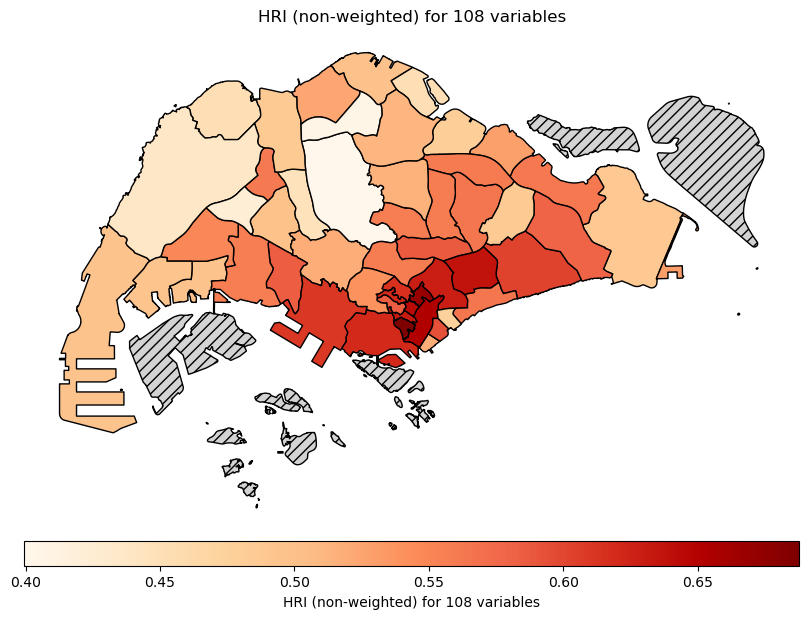

In [72]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_HRI(HRI_df, planningArea,HRI_var_name="HRI_non_weighted",ax = None,cmap='OrRd',
             title="",save_fp=None):
    HRI_planningArea = planningArea.merge(HRI_df[['PLN_AREA_N',HRI_var_name]],how="left")
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(10,7))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    HRI_planningArea.plot(column=HRI_var_name,cmap=cmap,ec="k",
                               legend=True, cax=cax, ax=ax,
                            #    scheme="Quantiles",
                               legend_kwds={"label": title, 
                                            "orientation": "horizontal"},
                               missing_kwds={
                                    "color": "lightgrey",
                                    "edgecolor": "black",
                                    "hatch": "///",
                                    "label": "Missing data"
                                })
    ax.axis('off')
    ax.set_title(title)
    if save_fp is not None:
        fig.savefig(save_fp, bbox_inches='tight')
    if ax is None:
        plt.show()
    return

plot_HRI(HRI_df_norm, planningArea_shp,HRI_var_name="HRI_non_weighted",title=f"HRI (non-weighted) for {len(HRI_df_norm.columns[1:-1])} variables",
         save_fp = os.path.join(r"data","HRI_non_weighted.png"))

# Old code

In [17]:
NonACHouseholds = r"HRI_analysis\data\Vulnerability\Non-AC Households.csv"
NonACHouseholds = pd.read_csv(NonACHouseholds)
# print(NonACHouseholds.columns)

medianIncome = r"HRI_analysis\data\Vulnerability\Household median income.csv"
medianIncome = pd.read_csv(medianIncome)
# print(medianIncome.columns)
medianIncome = medianIncome[['PLN_AREA_N','Population ','Estimated Median Income Range (incl. unemployed)']][medianIncome['PLN_AREA_N'].isin(planningArea_shp['PLN_AREA_N'].to_list())]
medianIncome = medianIncome.dropna()

ACHouseholds = NonACHouseholds.merge(medianIncome,how="inner",on='PLN_AREA_N')
ACHouseholds['Population '] = ACHouseholds['Population '].astype(int)
print(ACHouseholds.dtypes)
ACHouseholds['ACHouseholds'] = ACHouseholds['Population '] - ACHouseholds['Total']
ACHouseholds.head()

FID                                                   int64
Name                                                 object
Descriptio                                           object
PLN_AREA_N                                           object
PLN_AREA_C                                           object
CA_IND                                               object
Area                                                float64
Total                                                 int64
Q1                                                    int64
Q2                                                    int64
Q3                                                    int64
Q4                                                    int64
Q5                                                    int64
NonACperPlanningArea:TotalSGPopulation              float64
Population                                            int64
Estimated Median Income Range (incl. unemployed)    float64
dtype: object


FID   Name                                         Descriptio  \
0    0  kml_1  <center><table><tr><th colspan='2' align='cent...   
1    2  kml_3  <center><table><tr><th colspan='2' align='cent...   
2    3  kml_4  <center><table><tr><th colspan='2' align='cent...   
3    4  kml_5  <center><table><tr><th colspan='2' align='cent...   
4    5  kml_6  <center><table><tr><th colspan='2' align='cent...   

      PLN_AREA_N PLN_AREA_C CA_IND       Area  Total    Q1    Q2    Q3    Q4  \
0          BEDOK         BD      N  21.733905  19803  6913  4277  3233  1931   
1    BUKIT BATOK         BK      N  11.140156  11022  3741  2648  2107  1268   
2    BUKIT MERAH         BM      N  14.461198  12119  5384  2330  1780  1271   
3  BUKIT PANJANG         BP      N   9.019930   8847  2541  2166  1864  1054   
4    BUKIT TIMAH         BT      N  17.514937   4996   573   430   479   410   

     Q5  NonACperPlanningArea:TotalSGPopulation  Population   \
0  1399                                0.004897       276990   
1   627                                0.002725       158030   
2   726                                0.002997       151250   
3   498                                0.002188       138270   
4   791                                0.001235        77860   

   Estimated Median Income Range (incl. unemployed)  ACHouseholds  
0                                            7000.0        257187  
1                                            7000.0        147008  
2                                            5000.0        139131  
3                                            7000.0        129423  
4                                           15000.0         72864

In [ ]:
# ACHouseholds.to_csv(os.path.join(r"HRI_analysis\data\Vulnerability","ACHouseholds.csv"),index=False)

In [ ]:
# read dfs
# dfs = {fp_name: pd.read_csv(fp) for fp_name,fp in data_fps.items()}
# # rename planning area column
# # dfs = {df_name: df.rename(columns = lambda x: 'PLN_AREA_N' if 'PLN_AREA_N' in x else x) for df_name,df in dfs.items()}
# dfs = {df_name: df.rename(columns = lambda x: 'PLN_AREA_N' if bool(re.search("PLN_AREA_N|Planning Area",x)) else x) for df_name,df in dfs.items()}
# # drop duplicated columns
# dfs = {df_name: df.loc[:,~df.columns.duplicated()].copy() for df_name,df in dfs.items()}
# dfs



{'Hazard': [    OBJECTID *               PLN_AREA_N  ZONE_CODE  COUNT      AREA  \
  0            1                    BEDOK          1  24041  21636900   
  1            2                 BOON LAY          2   9095   8185500   
  2            3              BUKIT BATOK          3  12323  11090700   
  3            4              BUKIT MERAH          4  15399  13859100   
  4            5            BUKIT PANJANG          5   8968   8071200   
  5            6              BUKIT TIMAH          6  19463  17516700   
  6            7                   CHANGI          7  36600  32940000   
  7            8            CHOA CHU KANG          8   6477   5829300   
  8            9                 CLEMENTI          9  10575   9517500   
  9           10                  HOUGANG         10  14178  12760200   
  10          11              JURONG EAST         11  19711  17739900   
  11          12              JURONG WEST         12  16340  14706000   
  12          13                PASIR RIS

# Make some minor edits to df

In [7]:
# change service area to inaccessibility to service area
dfs['SGserviceArea']['InaccessibilityPublicTransit'] = dfs['SGserviceArea']['SA_PA_ratio'].apply(lambda x: 1-x)

dfs['SGserviceArea'].head()

# capitalise PLN_AREA_N
dfs['HouseholdMedianIncome']['PLN_AREA_N'] = dfs['HouseholdMedianIncome']['PLN_AREA_N'].str.upper().str.strip()
dfs['HouseholdMedianIncome'].head()

PLN_AREA_N    Total  No Employed Person  Below $1,000  $1,000 - $1,999  \
0        TOTAL  1372559              182445         27007            70569   
1   ANG MO KIO    60220               11455          1563             4228   
2        BEDOK    97551               16818          2203             5278   
3       BISHAN    29445                4412           508              983   
4  BUKIT BATOK    54297                5983           847             3328   

   $2,000 - $2,999  $3,000 - $3,999  $4,000 - $4,999  $5,000 - $5,999  \
0            69341            74185            70712            73493   
1             3572             4020             3381             3134   
2             5245             5521             4641             5102   
3              910             1252              996             1225   
4             3031             3136             3200             3206   

   $6,000 - $6,999  ...  $13,000 - $13,999  $14,000 - $14,999  \
0            68660  ...              41042              35595   
1             2943  ...               1425               1156   
2             3868  ...               2564               1838   
3             1307  ...                854                805   
4             2713  ...               1640               1475   

   $15,000 - $17,499  $17,500 - $19,999  $20,000 & Over  Median Index  \
0              76886              55127          190514      686279.5   
1               2661               1841            6466       30110.0   
2               4080               3349           17125       48775.5   
3               1801               1589            6864       14722.5   
4               2963               2037            7142       27148.5   

   Median Income Range (incl. unemployed)  Median Income (incl. unemployed)  \
0                         $7,000 - $7,999                              7000   
1                         $5,000 - $5,999                              5000   
2                         $7,000 - $7,999                              7000   
3                         $9,000 - $9,999                              9000   
4                         $7,000 - $7,999                              7000   

   Corrected Median Income Range (excl. unemployed)  \
0                                   $9,000 - $9,999   
1                                   $7,000 - $7,999   
2                                   $9,000 - $9,999   
3                                 $12,000 - $12,999   
4                                   $8,000 - $8,999   

   Median Income (excl. unemployed)  
0                              9000  
1                              7000  
2                              9000  
3                             12000  
4                              8000  

[5 rows x 26 columns]

In [8]:
# rename other columns
dfs_columns = [df.columns for df in dfs.values()]
print("number of dfs: ", len(list(dfs)))
print({i:df for i, df in enumerate(list(dfs))})
dfs_columns[15]

number of dfs:  20
{0: 'Clinic', 1: 'Greenspaces', 2: 'HouseholdMedianIncome', 3: 'NonACHouseholds', 4: 'PopulationDensityAge', 5: 'Schools', 6: 'Workplace', 7: 'RH0500am', 8: 'RH1400pm', 9: 'TA0500am', 10: 'TA1400pm', 11: 'WBGT0500am', 12: 'WBGT1400pm', 13: 'WS0500am', 14: 'WS1400pm', 15: 'MPEGaw', 16: 'Landsat 8 Daytime LST May 2018', 17: 'MODIS nighttime LST 2018050916', 18: 'SGserviceArea', 19: 'minMeantravelTimeHospital'}


Index(['PLN_AREA_N', 'Buildings', 'Impervious surfaces',
       'Non-vegetated pervious surfaces',
       'Vegetation with limited human management (w Tree Canopy)',
       'Vegetation with limited human management (w/o Tree Canopy)',
       'Vegetation with structure dominated by human management (w Tree Canopy)',
       'Vegetation with structure dominated by human management (w/o Tree Canopy)',
       'Freshwater swamp forest', 'Freshwater marsh', 'Mangrove',
       'Water courses', 'Water bodies', 'Marine', 'Buildings (km2)',
       'Vegetation (km2)', 'Total area (km2)', 'MPE (km2)', 'MPE'],
      dtype='object')

# Rename df columns

In [9]:
dfs_columns = [{'Clinic/pop':'ClinicPerPop'},
                {'Intersect_Statistics.SUM_ParkArea': 'ParkArea'},
                {'Median Income (incl. unemployed)': 'HouseholdMedianIncome'},
                # {'Q1':'IncomeQ1', 'Q2':'IncomeQ2', 'Q3':'IncomeQ3', 'Q4':'IncomeQ4', 'Q5':'IncomeQ5'},
                {'Total':'NonAirconPop'},
                {'PopulationDensity':'PopulationDensity','PopulationDensity_VulGroup':'VulGroupPerPopDensity'},
                {'Total':'StudentPop'},
                {'EmployedResidents_PlanningAreaofWork.csv.Total': 'WorkingPop'},
                {'MEAN': 'RH0500am'},
                {'MEAN': 'RH1400pm'},
                {'MEAN': 'TA0500am'},
                {'MEAN': 'TA1400pm'},
                {'MEAN': 'WBGT0500am'},
                {'MEAN': 'WBGT1400pm'},
                {'MEAN': 'WS0500am'},
                {'MEAN': 'WS1400pm'},
                {'MPE': 'MPE(Gaw)'},
                {'MEAN': 'LSTDayMEAN'},
                {'MEAN': 'LSTNightMEAN'},
                {'InaccessibilityPublicTransit': 'TransitExposure'},
                {'min_travel_time': 'HospitalTravelTime'},
                ]
dfs_filtered_columns = {df_name: df.loc[:,['PLN_AREA_N']+list(cols)].rename(columns=cols) for (df_name,df),cols in zip(dfs.items(),dfs_columns)}
dfs_filtered_columns

{'Clinic':                  PLN_AREA_N  ClinicPerPop
 0                     BEDOK      0.000296
 1                  BOON LAY      0.050000
 2               BUKIT BATOK      0.000266
 3               BUKIT MERAH      0.000417
 4             BUKIT PANJANG      0.000159
 5               BUKIT TIMAH      0.000360
 6                    CHANGI      0.006486
 7             CHOA CHU KANG      0.000130
 8                  CLEMENTI      0.000348
 9                   HOUGANG      0.000268
 10              JURONG EAST      0.000407
 11              JURONG WEST      0.000164
 12                PASIR RIS      0.000184
 13                  PIONEER      0.087500
 14                  PUNGGOL      0.000166
 15               QUEENSTOWN      0.000563
 16                  SELETAR      0.006667
 17                SEMBAWANG      0.000166
 18                 SENGKANG      0.000160
 19                SERANGOON      0.000308
 20                  KALLANG      0.000494
 21             LIM CHU KANG      0.000000
 

### Combine schools and workplace population as one single layer

In [10]:
df_occupation = dfs_filtered_columns['Schools'].merge(dfs_filtered_columns['Workplace'],on='PLN_AREA_N',how='inner')
df_occupation['PopDay'] = df_occupation['StudentPop'] + df_occupation['WorkingPop']
dfs_filtered_columns['PopDay'] = df_occupation[['PLN_AREA_N','PopDay']]
print(list(dfs_filtered_columns))
for columns_to_del in ["Schools","Workplace"]:
    if columns_to_del in dfs_filtered_columns:
        del dfs_filtered_columns[columns_to_del]

print(list(dfs_filtered_columns))        

['Clinic', 'Greenspaces', 'HouseholdMedianIncome', 'NonACHouseholds', 'PopulationDensityAge', 'Schools', 'Workplace', 'RH0500am', 'RH1400pm', 'TA0500am', 'TA1400pm', 'WBGT0500am', 'WBGT1400pm', 'WS0500am', 'WS1400pm', 'MPEGaw', 'Landsat 8 Daytime LST May 2018', 'MODIS nighttime LST 2018050916', 'SGserviceArea', 'minMeantravelTimeHospital', 'PopDay']
['Clinic', 'Greenspaces', 'HouseholdMedianIncome', 'NonACHouseholds', 'PopulationDensityAge', 'RH0500am', 'RH1400pm', 'TA0500am', 'TA1400pm', 'WBGT0500am', 'WBGT1400pm', 'WS0500am', 'WS1400pm', 'MPEGaw', 'Landsat 8 Daytime LST May 2018', 'MODIS nighttime LST 2018050916', 'SGserviceArea', 'minMeantravelTimeHospital', 'PopDay']


### Normalise income quintile and NonACPop by population of planning area

In [11]:
# pop_planningArea = dfs['PopulationDensityAge'][['PLN_AREA_N','ResidentPopTotalAll']]
# def normalise_by_totalpop(df,pop_planningArea):
#     # merge df of interest and pop_planningArea
#     df_merged = df.merge(pop_planningArea, on='PLN_AREA_N', how='left')
#     return df_merged

# normalise_by_totalpop(df,pop_planningArea)

# Merge dataframe by planning area

In [12]:
# merge all dfs_filtered_columns by PLN_AREA_N
from functools import reduce
# remove planning areas with island in it
selected_planningAreas = planningArea_shp[~planningArea_shp['PLN_AREA_N'].str.contains('ISLAND')]['PLN_AREA_N'].to_list()
HRI_df = reduce(lambda x, y: pd.merge(x, y, on = 'PLN_AREA_N',how='outer'), list(dfs_filtered_columns.values()))
print("length of HRI_df: ", len(HRI_df))
HRI_df = HRI_df[HRI_df['PLN_AREA_N'].isin(selected_planningAreas)]
print("length of HRI_df: ", len(HRI_df))
# cast object dataframe as numeric
HRI_df[HRI_df.columns[1:]] = HRI_df.iloc[:,1:].apply(lambda x: pd.to_numeric(x,errors="coerce"))
print(HRI_df.dtypes)
HRI_df.head()

length of HRI_df:  58
length of HRI_df:  52
PLN_AREA_N                object
ClinicPerPop             float64
ParkArea                 float64
HouseholdMedianIncome    float64
NonAirconPop             float64
PopulationDensity        float64
VulGroupPerPopDensity    float64
RH0500am                 float64
RH1400pm                 float64
TA0500am                 float64
TA1400pm                 float64
WBGT0500am               float64
WBGT1400pm               float64
WS0500am                 float64
WS1400pm                 float64
MPE(Gaw)                 float64
LSTDayMEAN               float64
LSTNightMEAN             float64
TransitExposure          float64
HospitalTravelTime       float64
PopDay                   float64
dtype: object


PLN_AREA_N  ClinicPerPop  ParkArea  HouseholdMedianIncome  NonAirconPop  \
0   ANG MO KIO      0.000401  0.866950                 5000.0       12225.0   
1        BEDOK      0.000296  1.547828                 7000.0       19803.0   
2       BISHAN      0.000344  1.318886                 9000.0        5977.0   
3     BOON LAY      0.050000       NaN                    NaN           0.0   
4  BUKIT BATOK      0.000266  0.948556                 7000.0       11022.0   

   PopulationDensity  VulGroupPerPopDensity   RH0500am   RH1400pm   TA0500am  \
0       11639.162530            4759.519506  82.479994  64.941191  27.867254   
1       12744.603300            5029.928998  82.746426  68.160184  28.111596   
2       11477.221750            4466.284872  82.577150  65.337676  28.017399   
3           4.829306               0.000000  78.908011  66.021886  28.189918   
4       14185.618000            5013.394705  82.883390  66.266992  27.633117   

   ...  WBGT0500am  WBGT1400pm  WS0500am  WS1400pm  MPE(Gaw)  LSTDayMEAN  \
0  ...   25.994581   32.403408  1.406218  1.988181  0.496771   42.713894   
1  ...   26.272072   33.014266  1.734917  1.534368  0.601766   43.408303   
2  ...   26.151150   32.624231  1.314745  1.788272  0.576928   43.890499   
3  ...   25.940038   32.243321  1.910929  2.161339  0.666014   46.122346   
4  ...   25.800132   32.723510  1.309292  1.853798  0.456185   40.845839   

   LSTNightMEAN  TransitExposure  HospitalTravelTime   PopDay  
0     25.849997         0.749842          428.467141  97523.0  
1     26.850954         0.692314          322.324601  89993.0  
2     26.384282         0.647359          350.152018  43646.0  
3     27.044281         0.898123          384.201006  19300.0  
4     26.186923         0.727883          229.263267  47273.0  

[5 rows x 21 columns]

### Get general statistics

In [13]:
# HRI_df.iloc[:,1:].describe(include='all').round(decimals=2).to_csv(r"data\HRI_stats_summary.csv")


### Identify variables with missing planning area data

In [14]:
selected_planningAreas = planningArea_shp[~planningArea_shp['PLN_AREA_N'].str.contains("ISLAND")]['PLN_AREA_N']
df_missing_planning_area = {df_name: ', '.join(list(set(selected_planningAreas)^set(HRI_df[~HRI_df[df_name].isna()]['PLN_AREA_N']))) for df_name in HRI_df.columns[1:]}
df_missing_planning_area = pd.DataFrame({'Variable': list(df_missing_planning_area), 'Missing data': list(df_missing_planning_area.values())})
df_missing_planning_area.to_csv(r"data\HRI_NAs_summary.csv",index=False)
df_missing_planning_area

Variable                                       Missing data
0            ClinicPerPop                                                   
1                ParkArea  STRAITS VIEW, BOON LAY, TENGAH, CHANGI BAY, WE...
2   HouseholdMedianIncome  STRAITS VIEW, CHANGI, MARINA EAST, BOON LAY, T...
3            NonAirconPop                                                   
4       PopulationDensity  STRAITS VIEW, MARINA EAST, CENTRAL WATER CATCH...
5   VulGroupPerPopDensity                                                   
6                RH0500am                                                   
7                RH1400pm                                                   
8                TA0500am                                                   
9                TA1400pm                                                   
10             WBGT0500am                                                   
11             WBGT1400pm                                                   
12               WS0500am                                                   
13               WS1400pm                                                   
14               MPE(Gaw)                                                   
15             LSTDayMEAN                                                   
16           LSTNightMEAN                      STRAITS VIEW, SINGAPORE RIVER
17        TransitExposure                                        MARINA EAST
18     HospitalTravelTime                                                   
19                 PopDay  STRAITS VIEW, MARINA EAST, TENGAH, LIM CHU KAN...

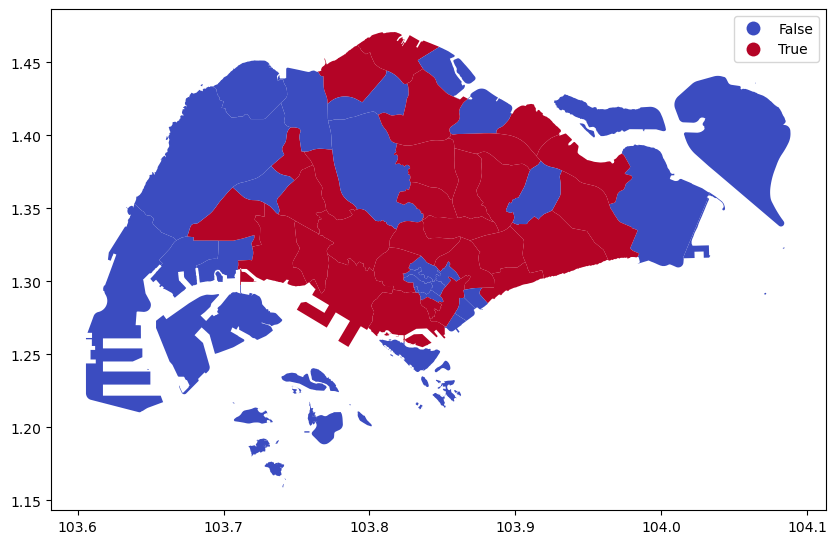

In [15]:
# add a column for planningArea that matches the planningArea_shp
# drop rows with NAs
HRI_valid = HRI_df.dropna()
planningArea_shp['valid_areas'] = planningArea_shp['PLN_AREA_N'].isin(HRI_valid['PLN_AREA_N'].to_list())
# print(planningArea_shp[~planningArea_shp['PLN_AREA_N'].isin(HRI_df['PLN_AREA_N'])]['PLN_AREA_N'])
ax = planningArea_shp.plot(column='valid_areas', cmap='coolwarm', legend=True, figsize=(10, 10))

# Calculate correlation between variables

In [16]:
# remove the first column (PLN_AREA_N) for correlation matrix
corr_matrix = HRI_df.iloc[:,1:].corr()
corr_matrix

ClinicPerPop  ParkArea  HouseholdMedianIncome  \
ClinicPerPop               1.000000 -0.084823               0.310456   
ParkArea                  -0.084823  1.000000              -0.106840   
HouseholdMedianIncome      0.310456 -0.106840               1.000000   
NonAirconPop              -0.345049 -0.135001              -0.458794   
PopulationDensity         -0.456698  0.068929              -0.391381   
VulGroupPerPopDensity     -0.385563 -0.186327              -0.482114   
RH0500am                  -0.303757  0.375848               0.058017   
RH1400pm                  -0.106910  0.134914               0.246383   
TA0500am                   0.108176 -0.409471              -0.120234   
TA1400pm                   0.173867 -0.157344              -0.160770   
WBGT0500am                -0.102335 -0.211834              -0.080424   
WBGT1400pm                -0.186901 -0.366252              -0.030587   
WS0500am                   0.176133  0.172190               0.100153   
WS1400pm                   0.183654  0.417568               0.074472   
MPE(Gaw)                  -0.047823 -0.357661              -0.277864   
LSTDayMEAN                 0.082480 -0.550590              -0.365429   
LSTNightMEAN              -0.049276 -0.428224               0.058580   
TransitExposure            0.127346  0.261898               0.086044   
HospitalTravelTime         0.229354  0.292816               0.050738   
PopDay                    -0.118914  0.015354               0.026391   

                       NonAirconPop  PopulationDensity  VulGroupPerPopDensity  \
ClinicPerPop              -0.345049          -0.456698              -0.385563   
ParkArea                  -0.135001           0.068929              -0.186327   
HouseholdMedianIncome     -0.458794          -0.391381              -0.482114   
NonAirconPop               1.000000           0.803901               0.823714   
PopulationDensity          0.803901           1.000000               0.989086   
VulGroupPerPopDensity      0.823714           0.989086               1.000000   
RH0500am                  -0.267716          -0.162917              -0.319335   
RH1400pm                  -0.412393          -0.300615              -0.424072   
TA0500am                   0.016796           0.068871               0.083862   
TA1400pm                   0.270826           0.129079               0.309856   
WBGT0500am                -0.187257          -0.045936              -0.159081   
WBGT1400pm                 0.144603           0.224978               0.368625   
WS0500am                  -0.322344          -0.356292              -0.435429   
WS1400pm                  -0.313104          -0.366825              -0.472993   
MPE(Gaw)                   0.184009           0.198134               0.122421   
LSTDayMEAN                 0.306804           0.181417               0.362578   
LSTNightMEAN               0.137333           0.218560               0.269923   
TransitExposure           -0.115112          -0.298855              -0.398920   
HospitalTravelTime        -0.256226          -0.244180              -0.324164   
PopDay                     0.289447           0.069223               0.084576   

                       RH0500am  RH1400pm  TA0500am  TA1400pm  WBGT0500am  \
ClinicPerPop          -0.303757 -0.106910  0.108176  0.173867   -0.102335   
ParkArea               0.375848  0.134914 -0.409471 -0.157344   -0.211834   
HouseholdMedianIncome  0.058017  0.246383 -0.120234 -0.160770   -0.080424   
NonAirconPop          -0.267716 -0.412393  0.016796  0.270826   -0.187257   
PopulationDensity     -0.162917 -0.300615  0.068871  0.129079   -0.045936   
VulGroupPerPopDensity -0.319335 -0.424072  0.083862  0.309856   -0.159081   
RH0500am               1.000000  0.640407 -0.452790 -0.479704    0.263211   
RH1400pm               0.640407  1.000000  0.259224 -0.925015    0.771312   
TA0500am              -0.452790  0.259224  1.000000 -0.411173    0.740545   
TA1400pm              -0.479704 -0.925

C:\Users\hypak\AppData\Local\Temp\ipykernel_42584\337735431.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, 10) # jet doesn't have white color
C:\Users\hypak\AppData\Local\Temp\ipykernel_42584\337735431.py:27: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  text = ax.text(j, i, f"{corr_array[i, j]:.3f}",


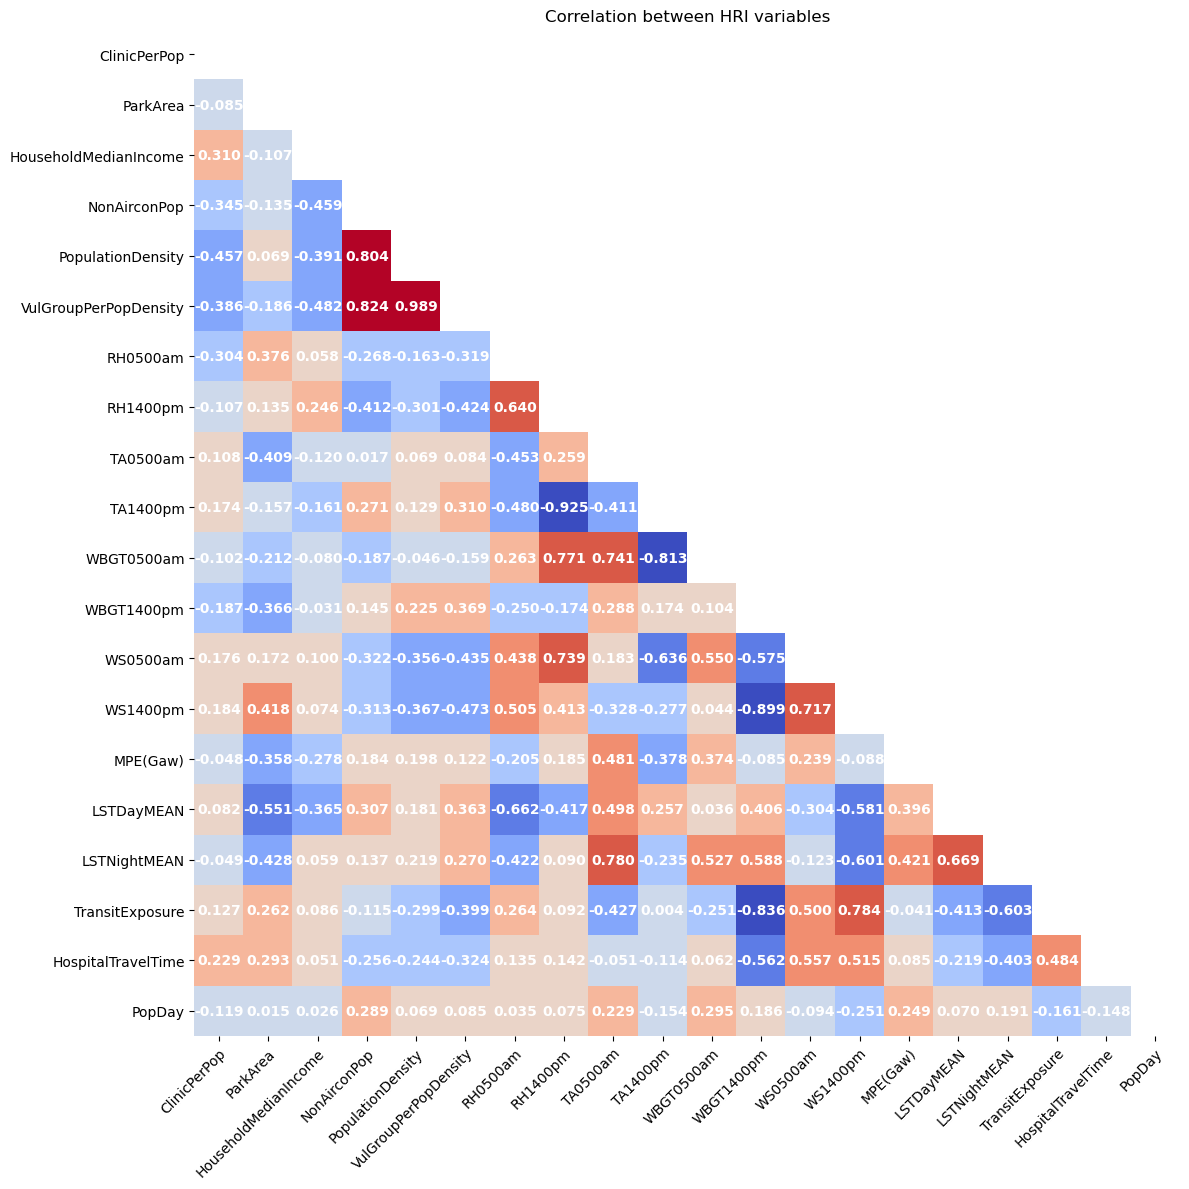

In [ ]:


correlation_plot(corr_matrix, title='Correlation between HRI variables',cmap='coolwarm')
# plt.figure(figsize=(8, 6))  # Adjust figure size as needed
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
# plt.title('Correlation Matrix')
# plt.show()

# Pairwise covariance of columns

In [18]:
# remove the first column (PLN_AREA_N) for correlation matrix
cov_matrix = HRI_df.iloc[:,1:].cov()
cov_matrix

ClinicPerPop     ParkArea  HouseholdMedianIncome  \
ClinicPerPop               0.000551    -0.003126           4.021000e+00   
ParkArea                  -0.003126    23.128482          -2.928104e+02   
HouseholdMedianIncome      4.021000  -292.810403           1.473247e+07   
NonAirconPop             -49.404120 -3989.584059          -9.374945e+06   
PopulationDensity        -83.175699   355.552115          -9.595582e+06   
VulGroupPerPopDensity    -23.806552 -2287.554111          -3.970736e+06   
RH0500am                  -0.012706     2.391982           2.337984e+02   
RH1400pm                  -0.009872     1.987788           2.476248e+03   
TA0500am                   0.000708    -0.474886          -8.758845e+01   
TA1400pm                   0.001840    -0.270673          -1.946447e+02   
WBGT0500am                -0.000625    -0.212079          -5.772527e+01   
WBGT1400pm                -0.002365    -0.885578          -4.374785e+01   
WS0500am                   0.002667     0.369821           1.138051e+02   
WS1400pm                   0.002224     0.810495           7.231950e+01   
MPE(Gaw)                  -0.000171    -0.218807          -1.069461e+02   
LSTDayMEAN                 0.004685    -5.174914          -2.048051e+03   
LSTNightMEAN              -0.000753    -1.272952           9.870044e+01   
TransitExposure            0.000689     0.289783           4.948714e+01   
HospitalTravelTime         1.013633   224.924908           1.933363e+04   
PopDay                  -128.975268   538.408474           4.986643e+06   

                       NonAirconPop  PopulationDensity  VulGroupPerPopDensity  \
ClinicPerPop          -4.940412e+01      -8.317570e+01          -2.380655e+01   
ParkArea              -3.989584e+03       3.555521e+02          -2.287554e+03   
HouseholdMedianIncome -9.374945e+06      -9.595582e+06          -3.970736e+06   
NonAirconPop           3.720230e+07       3.646812e+07           1.321494e+07   
PopulationDensity      3.646812e+07       5.428070e+07           1.899982e+07   
VulGroupPerPopDensity  1.321494e+07       1.899982e+07           6.918429e+06   
RH0500am              -2.909704e+03      -1.797160e+03          -1.496720e+03   
RH1400pm              -9.894367e+03      -6.109530e+03          -4.387677e+03   
TA0500am               2.856979e+01       1.363313e+02           6.151505e+01   
TA1400pm               7.446080e+02       3.158218e+02           3.673808e+02   
WBGT0500am            -2.971614e+02      -7.376595e+01          -1.088655e+02   
WBGT1400pm             4.754245e+02       8.205112e+02           5.226469e+02   
WS0500am              -1.268061e+03      -1.209121e+03          -7.386801e+02   
WS1400pm              -9.850335e+02      -1.077966e+03          -6.417059e+02   
MPE(Gaw)               1.712762e+02       1.878761e+02           4.913945e+01   
LSTDayMEAN             4.528265e+03       2.798670e+03           2.307764e+03   
LSTNightMEAN           5.380695e+02       1.009534e+03           4.570295e+02   
TransitExposure       -1.608691e+02      -5.024080e+02          -2.398201e+02   
HospitalTravelTime    -2.942282e+05      -3.207146e+05          -1.605257e+05   
PopDay                 8.965251e+07       2.568088e+07           1.105099e+07   

                          RH0500am      RH1400pm     TA0500am     TA1400pm  \
ClinicPerPop             -0.012706     -0.009872     0.000708     0.001840   
ParkArea                  2.391982      1.987788    -0.474886    -0.270673   
HouseholdMedianIncome   233.798351   2476.247695   -87.588454  -194.644661   
NonAirconPop          -2909.704087  -9894.367061    28.569789   744.608010   
PopulationDensity     -1797.160003  -6109.530171   136.331333   315.821794   
VulGroupPerPopDensity -1496.719749  -4387.676531    61.515050   367.380789   
RH0500am                  3.175262      4.488874    -0.225010    -0.385315   
RH1400pm                  4.488874     15.473301     0.284368    -1.640184   
TA0500am                 -0.225010      0.2

### HRI_dfs
- Drop rows with NAs
- imputation with 0

In [20]:
# remove rows with NAs
print("NAs in HRI_df:", HRI_df.isna().sum())
HRI_df_noNAs = HRI_df.dropna()
print("length of HRI_df_noNAs:", len(HRI_df_noNAs))
HRI_df_noNAs.head()

# imput NAs with 0
HRI_imputed = HRI_df.fillna(0)
print("length of HRI_imputed:", len(HRI_imputed))
HRI_imputed.head()

HRI_dfs = {'noNAs': HRI_df_noNAs,
            'imputed': HRI_imputed}

NAs in HRI_df: PLN_AREA_N                0
ClinicPerPop              0
ParkArea                 10
HouseholdMedianIncome    22
NonAirconPop              0
PopulationDensity         6
VulGroupPerPopDensity     0
RH0500am                  0
RH1400pm                  0
TA0500am                  0
TA1400pm                  0
WBGT0500am                0
WBGT1400pm                0
WS0500am                  0
WS1400pm                  0
MPE(Gaw)                  0
LSTDayMEAN                0
LSTNightMEAN              2
TransitExposure           1
HospitalTravelTime        0
PopDay                   10
dtype: int64
length of HRI_df_noNAs: 29
length of HRI_imputed: 52


In [21]:
from sklearn.decomposition import PCA

pca_results = dict()
for df_type, df in HRI_dfs.items():
    sc = StandardScaler()
    HRI_standardized = sc.fit_transform(df.iloc[:,1:])  # Exclude PLN_AREA_N for scaling
    # print(HRI_standardized)
    pca = PCA(n_components=None)
    HRI_PCA = pca.fit(HRI_standardized)
    # Percentage of variance explained by each of the selected components. 
    # The values are sorted by decreasing explained_variance_, thus it doesnt directly correspond to the order of the original features.
    var = pca.explained_variance_ratio_
    # features contribute to principal components through the loadings (i.e. coefficients of the linear combination of the original features that form the principal components).
    # components_ tells us how strongly each original feature correlates with each PC
    loadings = pca.components_
    # Create a DataFrame for loadings with original feature names, display the loadings for each principal component
    # look at the absolute values in each row, the large the absolute value, the more influence that feature has on that PC
    # each row in loadings_df correspond to a principal component, and each column corresponds to an original feature. The values indicate how much each feature contributes to that PC
    # e.g. the first row corresponds to the first principal component, and the values in that row indicate how much each original feature contributes to that PC
    loadings_df = pd.DataFrame(loadings, columns=df.columns[1:])
    pca_results[df_type] = {'explained_variance': var,'loadings_df': loadings_df}

In [58]:

pca_results['imputed']['loadings_df'].apply(lambda x: x*pca_results['imputed']['explained_variance'].tolist(),axis=0).abs().sum(axis=0).sort_values(ascending=False).to_frame(name="sum of absolute loadings").to_csv(os.path.join(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents - Heat Risk Index Development\Data\Data analysis","PCA_ranking_absolute_loadings.csv"))


In [ ]:


fig, ax = plt.subplots()
for df_type in pca_results.keys():
    ax = scree_plot(pca_results[df_type]['explained_variance'], title=f'PCA Scree Plot', ax=ax,label=df_type)
# plot legend from handles
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, loc='upper right', title='Data Type')
plt.show()

# Plot loadings

In [23]:
def plot_loadings(loadings_df,n_components=None,title="",cmap="coolwarm"):
    """ 
    plot ABSOLUTE loadings in the form of a heatmap
    Args:
        loadings_df (pd.Dataframe): loadings for each principal component
        n_components (int or None): if None, plot all n_components
        cmap (str): matplotlib colormap
    """
    xlabels = loadings_df.columns
    ylabels = [i+1 for i in loadings_df.index]

    fig, ax = plt.subplots(figsize=(12,12))
    if n_components is not None:
        loadings_df = np.abs(loadings_df.iloc[:n_components,:].values)
    else:
        loadings_df = np.abs(loadings_df.values)
    im = ax.imshow(loadings_df,cmap=cmap, aspect='auto')

    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(range(len(xlabels)), labels=xlabels,
                rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(len(ylabels)), labels=ylabels)

    # Loop over data dimensions and create text annotations.
    for i in range(len(ylabels)):
        for j in range(len(xlabels)):
            text = ax.text(j, i, f"{loadings_df[i, j]:.3f}", 
                        ha="center", va="center", color="w",fontweight='bold')
    ax.spines[:].set_visible(False)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.set_title(f"Absolute loadings for each principle component\n({title})")
    fig.tight_layout()
    plt.show()

# plot_loadings(loadings_df=pca_results['imputed']['loadings_df'],n_components=None,cmap="coolwarm")
    

# Sum of all absolute loadings for the first 5 principle components

In [24]:
pd.DataFrame(pca_results['imputed']['loadings_df'].iloc[:5,:].abs().sum(axis=0).sort_values(ascending=False))

0
LSTNightMEAN           1.083439
PopulationDensity      1.008218
VulGroupPerPopDensity  0.987358
MPE(Gaw)               0.976818
WBGT1400pm             0.972608
NonAirconPop           0.961302
PopDay                 0.959393
RH1400pm               0.955209
RH0500am               0.950685
LSTDayMEAN             0.908850
HouseholdMedianIncome  0.898117
TA0500am               0.881233
WS0500am               0.867434
TransitExposure        0.832324
ClinicPerPop           0.822771
WS1400pm               0.822423
TA1400pm               0.804041
WBGT0500am             0.780704
HospitalTravelTime     0.767788
ParkArea               0.625119

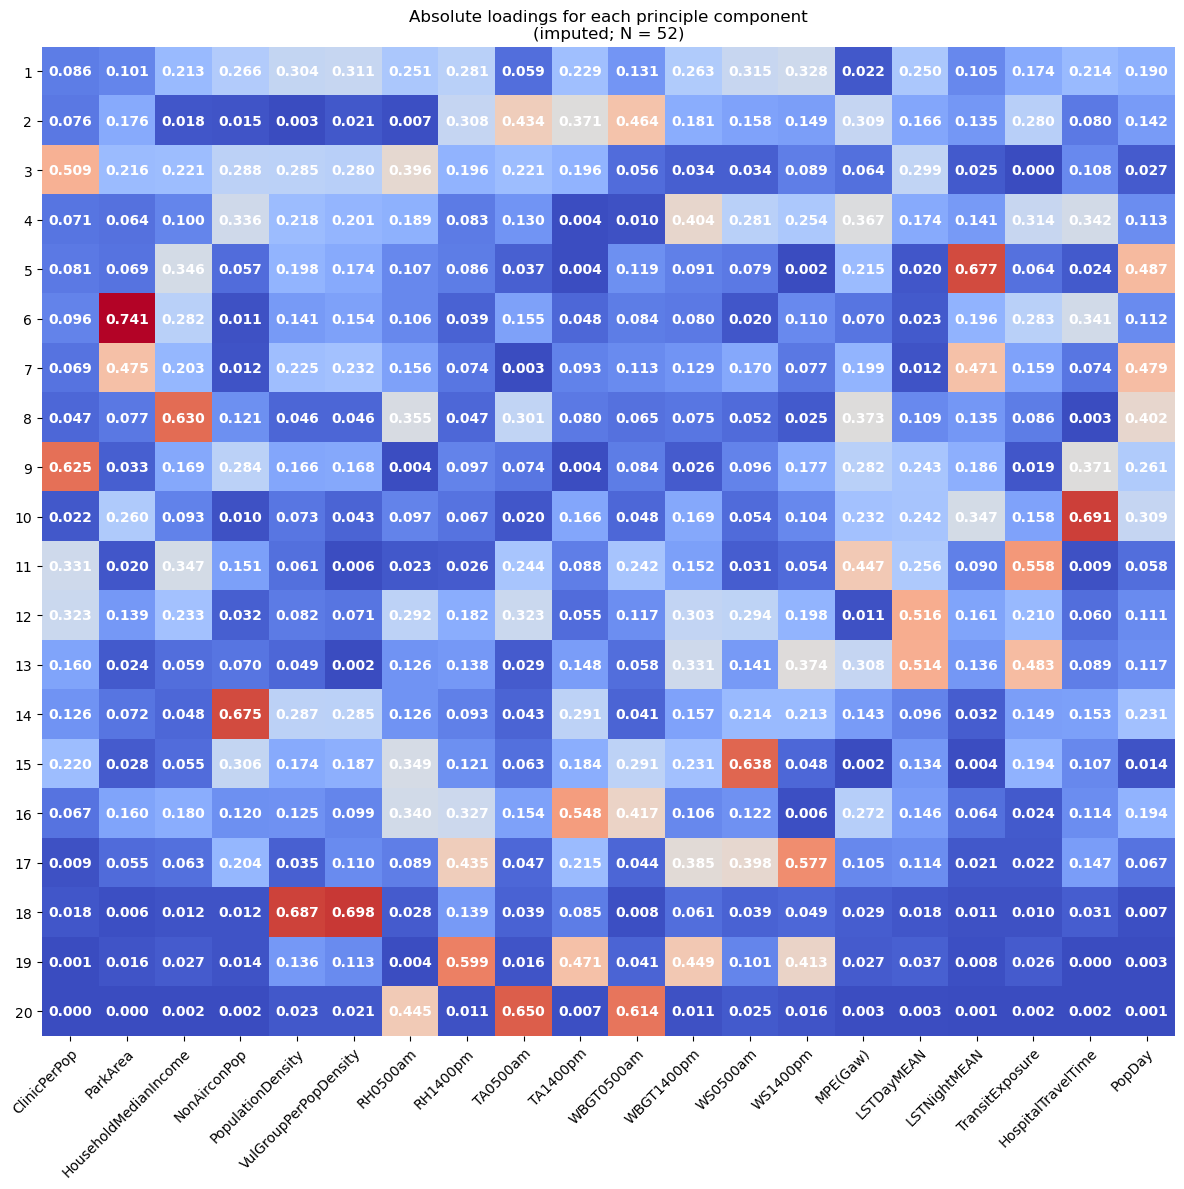

In [25]:
for df_type, result in pca_results.items():
    plot_loadings(loadings_df=pca_results[df_type]['loadings_df'],n_components=None,cmap="coolwarm",title=f"{df_type}; N = {len(HRI_dfs[df_type])}" )

In [26]:
save_dir = r"data"
for df_type, result in pca_results.items():
    loadings_ranking = result['loadings_df'].iloc[[0],:].abs().melt(value_name=f"PCA Absolute Loadings ({df_type})").sort_values(by=f"PCA Absolute Loadings ({df_type})",ascending=False)
    # loadings_ranking.to_csv(os.path.join(save_dir,f"loadings_ranking_{df_type}.csv"),index=False)